### Import libraries and features 

In [1]:
import gc
import sys
import os 
import pandas as pd 
import numpy as np 
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
home = os.path.expanduser("~")
sys.path.append(f"{home}/Documents/projects/CarPriceRegression/Machine_Learning/scripts/")

In [3]:
from util import *
%load_ext autoreload
%autoreload 2

### Import data and split into train and test 

In [4]:
data = pd.read_csv(f"{home}/Documents/projects/CarPriceRegression/Processed_Data/car_onehot_data.csv")
features, y = data.drop("price",axis=1), data.price
X_train, X_test, y_train, y_test = train_test_split(features,y,test_size=0.2,random_state=2020)

In [5]:
X_train.shape,y_train.shape, X_test.shape,y_test.shape

((79348, 206), (79348,), (19838, 206), (19838,))

### garbage collect

In [6]:
gc.collect()
%reset -f out

Flushing output cache (1 entries)


### Generate a base model first 

In [7]:
base_model = ElasticNet(random_state=2020)

In [8]:
base_model.fit(X_train,y_train)

ElasticNet(random_state=2020)

In [9]:
regression_metrics(base_model,X_train,y_train,X_test,y_test)

,r2_score,rmse
train,0.552169,6593.730208
test,0.546322,6682.286317


### Base model predicts r2 score of ~0.55. Not terrible but a root mean squared error of 6682 for a used car price is quite terrible. Let's perform gridsearch to improve the results

### Key parameters

* alpha: default 1 
* l1__ratio: default 0.5 
* max_iter: default 1000
* tol: default 1e-5

In [10]:
params = {
    "alpha":[0.0005,0.005,0.05,0.5,1],
    "l1_ratio":[1,0.5,0],
    "max_iter":[1000,2000],
    "tol":[1e-4,5e-5]
}

In [11]:
searchGrid = GridSearchCV(base_model,params,scoring="r2",n_jobs=22)

In [12]:
searchGrid.fit(X_train,y_train)

In [13]:
searchGrid.best_score_

In [14]:
searchGrid.best_params_

In [15]:
final_model = searchGrid.best_estimator_

In [18]:
regression_metrics(final_model,X_train,y_train,X_test,y_test)

,r2_score,rmse
train,0.840607,3933.772235
test,0.833403,4049.344581


### Better than before but 4049 is very high error as well. 

### Let's look at feature importances and which samples have bad results

### Coefficients and look for feature ranking

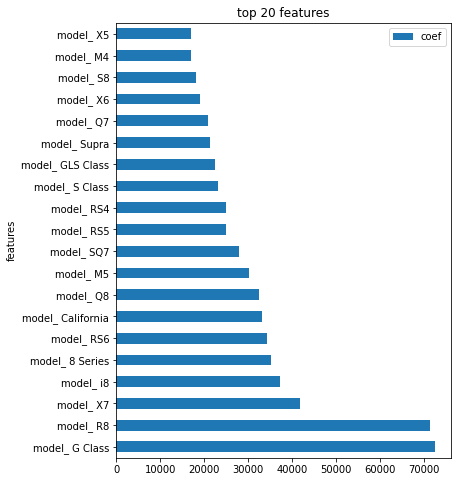

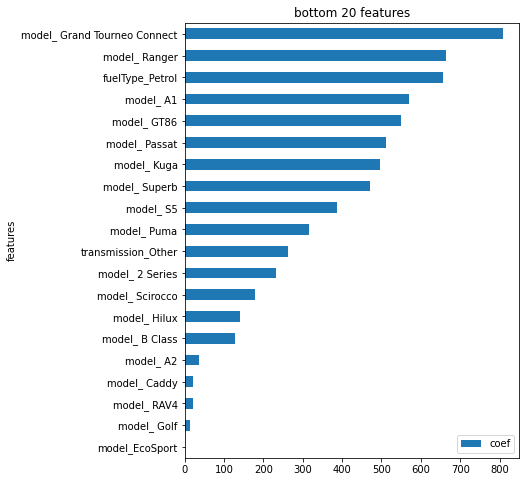

In [19]:
feature_table = linear_feature_importance(X_train.columns,final_model)

### Remove features with very low coef to see if it improve performance. 

In [20]:
features_remove = feature_table.sort_values("score").head(5).features
X_train_trimmed,X_test_trimmed = X_train.drop(features_remove,axis=1),X_test.drop(features_remove,axis=1)

In [21]:
base_model.fit(X_train_trimmed,y_train)

ElasticNet(random_state=2020)

In [22]:
regression_metrics(base_model,X_train_trimmed,y_train,X_test_trimmed,y_test)

,r2_score,rmse
train,0.552169,6593.729937
test,0.546322,6682.285834


### Try gridsearch again

In [23]:
searchGrid.fit(X_train_trimmed,y_train)

In [88]:
searchGrid.best_score_

0.8380124656538495

In [66]:
searchGrid.best_params_

{'alpha': 0.005, 'l1_ratio': 1, 'max_iter': 1000, 'tol': 0.0001}

In [24]:
model_trimmed = searchGrid.best_estimator_

In [25]:
regression_metrics(model_trimmed,X_train_trimmed,y_train,X_test_trimmed,y_test)

,r2_score,rmse
train,0.840607,3933.773140
test,0.833404,4049.335707


### Similar performance but with less features
### Look at examples where the price is way off 

In [26]:
price_diff_table = price_diff(model_trimmed,features.drop(features_remove,axis=1),y)

### There are many features narrow down to non model related features

In [28]:
sub_features = [f for f in features.columns if "model" not in f]

In [29]:
price_diff_table.sort_values("price_diff_abs",ascending=False)[:1000][sub_features].describe()

,binned_year,mil_cat,binned_mpg,engine_binned,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.0,1000.000000,1000.0,1000.000000
mean,1.467000,3.899000,2.242000,0.318000,0.639000,0.0,0.043000,0.0,0.003000,0.0,0.613000
std,0.698139,0.988826,1.023955,0.516859,0.480531,0.0,0.202959,0.0,0.054717,0.0,0.487307
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
25%,1.000000,4.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
50%,1.000000,4.000000,2.000000,0.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000
75%,2.000000,4.000000,3.000000,1.000000,1.000000,0.0,0.000000,0.0,0.000000,0.0,1.000000
max,4.000000,5.000000,4.000000,2.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000


In [31]:
price_diff_table.sort_values("price_diff_abs",ascending=False)[:5][sub_features+["price_diff_pct"]]

,binned_year,mil_cat,binned_mpg,engine_binned,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct
39336,1,5,1,1,0,0,0,0,0,0,0,-1813.180369
20061,1,0,1,0,0,0,0,0,0,0,1,-1525.415593
39711,1,2,1,1,0,0,0,0,0,0,0,-1223.145260
39978,1,5,1,0,1,0,0,0,0,0,1,-958.721608
71819,1,0,2,0,1,0,0,0,0,0,0,-920.799246


In [133]:
price_diff_table.sort_values("price_diff_abs")[:1000][sub_features].describe()

,binned_year,mil_cat,binned_mpg,engine_binned,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.0,1000.000000,1000.0,1000.000000,1000.0,1000.000000
mean,3.275000,1.755000,2.790000,0.090000,0.474000,0.0,0.299000,0.0,0.036000,0.0,0.472000
std,0.617865,0.972585,0.985328,0.286325,0.499573,0.0,0.458049,0.0,0.186383,0.0,0.499465
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
25%,3.000000,1.000000,2.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
50%,3.000000,2.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000
75%,4.000000,2.000000,4.000000,0.000000,1.000000,0.0,1.000000,0.0,0.000000,0.0,1.000000
max,4.000000,5.000000,4.000000,1.000000,1.000000,0.0,1.000000,0.0,1.000000,0.0,1.000000


In [32]:
price_diff_table.sort_values("price_diff_abs")[:5][sub_features+["price_diff_pct"]]

,binned_year,mil_cat,binned_mpg,engine_binned,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,price_diff_pct
77343,3,3,4,0,0,0,0,0,1,0,0,0.000318
17852,3,2,2,0,1,0,0,0,0,0,1,-0.000962
17842,3,2,2,0,1,0,0,0,0,0,1,-0.000962
81029,2,3,2,0,0,0,1,0,0,0,1,0.001127
2646,3,1,3,0,1,0,0,0,0,0,1,0.001196


### summary:

* cars that are older tend to be harder to predict for the price. 
* cars with medium size engine, semi automatic transmission tend to be easier to predict for the price. 

In [134]:
price_diff_table.price_diff_abs.describe()

count    99186.000000
mean        17.313187
std         24.530352
min          0.000318
25%          5.571546
50%         12.168941
75%         21.952297
max       1813.180369
Name: price_diff_abs, dtype: float64

### Overally not a bad first model:
* 17% price difference 
* 22% price different at 75% quantile. 
* car price appears to be very dependent upon the brand as well

_____